In [4]:
# Importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import warnings
import string
import nltk
from nltk.corpus import stopwords
from tensorflow import keras
import gensim.models
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import tensorflow as tf
from tensorflow.keras import initializers, preprocessing
import tensorflow_hub as hub
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.manifold import TSNE

# Import Data

In [3]:
df_train = pd.read_csv('../dataset/raw/dataset.csv')
df_train=df_train[['text','category']]
df_train

,text,category
0,tv future in the hands of viewers with home th...,tech
1,worldcom boss left books alone former worldc...,business
2,tigers wary of farrell gamble leicester say ...,sport
3,yeading face newcastle in fa cup premiership s...,sport
4,ocean s twelve raids box office ocean s twelve...,entertainment
...,...,...
2220,cars pull down us retail figures us retail sal...,business
2221,kilroy unveils immigration policy ex-chatshow ...,politics
2222,rem announce new glasgow concert us band rem h...,entertainment
2223,how political squabbles snowball it s become c...,politics


In [9]:
df_train.describe(include='all')

,text,category
count,2225,2225
unique,2126,5
top,kennedy questions trust of blair lib dem leade...,sport
freq,2,511


In [10]:
import plotly.express as px
import cufflinks as cf

cf.go_offline()
df_train["category"].iplot(kind='hist', bins=1)
df_train["category"].iplot(kind='box', bins=1)

# Texts visualization in 2D Space

In order to convert from text to Numberical representation there are multiple techniques, some of the very popular ones are mentioned below:

* Count Vectorization
* TIDIF Vectorization
* Bag Of Word Embeddings
* Word2Vec

For this analysis purpose i am going to use **Tensorflow_Hub Universal Senetence Encoder**.

In [11]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [12]:
text_vect = embed(df_train['text'])
x_reduced = TSNE(n_components=2, random_state=0).fit_transform(text_vect)

In [13]:
print(x_reduced.shape) 

(2225, 2)


In [14]:
x_reduced_df = pd.DataFrame(x_reduced, columns=['0', '1'])

In [15]:
x_reduced_with_category = pd.concat([x_reduced_df, df_train['category'].reset_index(drop=True)], axis=1)
category_count = df_train['category'].value_counts().reset_index()
category_count.columns = ['category', 'count']


In [16]:
merged_df = pd.merge(
    x_reduced_with_category,
    category_count,
    on='category',
    how='left'
)
merged_df

,0,1,category,count
0,-26.455349,35.547066,tech,401
1,-24.313555,1.084221,business,510
2,52.036133,-4.800806,sport,511
3,55.382748,-18.554737,sport,511
4,7.062020,49.604195,entertainment,386
...,...,...,...,...
2220,-51.903587,-27.896784,business,510
2221,-5.756366,-19.283047,politics,417
2222,12.793842,10.242795,entertainment,386
2223,3.519649,-8.807413,politics,417


In [17]:
# Plot visualisasi
fig = px.scatter(
    merged_df,
    x='0',  # Kolom x untuk visualisasi
    y='1',  # Kolom y untuk visualisasi
    color='category',  # Warna berdasarkan kategori
    size='count',  # Ukuran berdasarkan count
    title="t-SNE Visualization of Text Data with Categories"
)

fig.show()

# Preprocessing

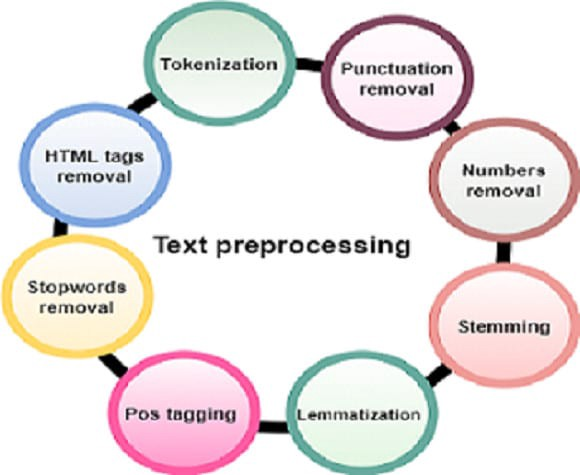

In [18]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

## Wordcloud

Word Cloud is basically the pictorial representation of collective words which will be used for a specific task. in our case it is a removal of stop words.<br>
Why we are removing stop words ?? it's becasue these stop words does not mean anything in context to sentences hence it is not necessory when we compose the meanings of the sentences.

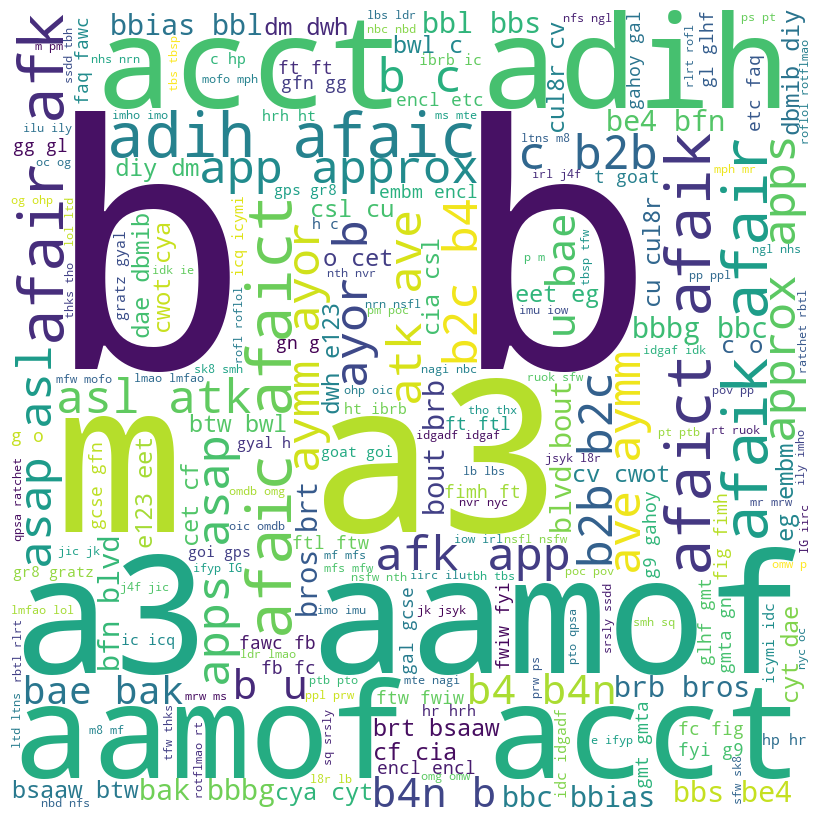

In [19]:
#Generating Word Coud

token = list(abbreviations.keys())
comment_words = ''
stopWords = set(STOPWORDS)


for i in range(len(token)):
    token[i] = token[i].lower()
      
    comment_words += " ".join(token)+" "
    
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopWords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

## Filters

The purpose of these filters to ignore and remove such tokens or words which does not contribute when it comes to classification. It will create only noise if not removed.<br> A clean text reprepresents much more meaning then with noises, hence include few common filters used.

1. Removing url
2. Removing HTML 
3. Removing Not_Ascii
4. Removing Word Abbreveations
5. Removing Mentions
6. Removing Numbers
7. Removing Emojis : Sad, Smile and Heart
8. Removing Elongated Words
9. Removing Punctuations
10. Lemmatization/ Stemming

The above all should take care of our most of the textual problems!!


In [20]:
# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL', text)

# Remove HTML beacon
def remove_HTML(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

# Remove @ and mention, replace by USER
def remove_mention(text):
    at = re.compile(r'@\S+')
    return at.sub(r'USER', text)

# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

# Replace some others smileys with SADFACE
def transcription_sad(text):
    smiley = re.compile(r'[8:=;][\'`\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

# Replace some smileys with SMILE
def transcription_smile(text):
    smiley = re.compile(r'[8:=;][\'`\-]?[)dDp]')
    return smiley.sub(r'SMILE', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

# Factorize elongated words, add ELONG
def remove_elongated_words(text):
    rep = re.compile(r'\b(\S*?)([a-z])\2{2,}\b')
    return rep.sub(r'\1\2 ELONG', text)

# Factorize repeated punctuation, add REPEAT
def remove_repeat_punct(text):
    rep = re.compile(r'([!?.]){2,}')
    return rep.sub(r'\1 REPEAT', text)

# Remove all punctuations
def remove_all_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Remove punctuations
def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" 
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')   
    return text

# Remove all English stopwords
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    return text

# Perform stemming
def stemming(text):
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

# Perform lemmatization
def lemmatization(text):
    lm = WordNetLemmatizer()
    text = ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])
    return text

# Remove words shorter than 4 characters
def remove_short_words(text):
    text = ' '.join([word for word in text.split() if len(word) >= 4])
    return text

In [21]:
def clean_text(text):
    # Step 1: Remove non-text components
    text = remove_URL(text)             # Remove URLs
    text = remove_HTML(text)            # Remove HTML tags
    text = remove_not_ASCII(text)       # Remove non-printable characters
    
    # Step 2: Replace and preprocess text
    text = replace_abbrev(text)         # Replace abbreviations
    text = remove_mention(text)         # Remove mentions (@user -> USER)
    text = remove_number(text)          # Replace numbers with NUMBER
    
    # Step 3: Handle emoticons and expressions
    text = transcription_sad(text)      # Replace sad smileys
    text = transcription_smile(text)    # Replace smiley faces
    text = transcription_heart(text)    # Replace <3 with HEART
    
    # Step 4: Handle repetitions and elongated words
    text = remove_elongated_words(text) # Normalize elongated words
    text = remove_repeat_punct(text)    # Reduce repeated punctuations
    
    # Step 5: Remove punctuation and stopwords
    text = remove_all_punct(text)       # Remove all punctuations
    text = remove_punct(text)           # Handle remaining punctuations
    text = lemmatization(text)          # Perform lemmatization
    
    # Step 6: Lowercase and filter short words
    text = text.lower()                 # Convert text to lowercase
    text = remove_short_words(text)     # Remove words shorter than 4 characters

    return text

## Cleaning text

In [22]:
#cleaning text in data frames
df_train["textclean"] = df_train["text"].apply(clean_text)

Below result shows how the Text loosk like Before and After Pre Processing and does that effect much??

In [23]:
df_train[["textclean", "text", "category"]].iloc[90]

textclean    slovakia reach hopman final slovakia will play...
text         slovakia reach hopman cup final slovakia will ...
category                                                 sport
Name: 90, dtype: object

# Feature preparation for training purpose

In [24]:
sentences = df_train["textclean"].apply(lambda x: x.lower()).tolist()
# generating training data matrix
embed_matrix = []
for sent in sentences:
    embed_matrix.append(np.array(embed([sent])[0]).tolist()) 

In [25]:
# Transforming catagories label to 
lb = LabelBinarizer().fit(list(set(df_train['category'].tolist())))

# Train Test Split for Training

In [26]:
# setting up train data and labels (processed)
X, Y = np.array(embed_matrix), lb.transform(df_train['category'].tolist())

In [27]:
# splitting up data into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.3, shuffle=True)

In [28]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1557, 512), (668, 512), (1557, 5), (668, 5))

# Model and Dense Architecture

In any neural network, a dense layer is a layer that is deeply connected with its preceding layer which means the neurons of the layer are connected to every neuron of its preceding layer. This layer is the most commonly used layer in artificial neural network networks.

In [29]:
# Model Architecture
ann = tf.keras.models.Sequential()
ann.add(tf.keras.Input(shape=(512,)))  # Perbaikan dilakukan di sini
ann.add(tf.keras.layers.Dense(units=256, activation='relu'))
ann.add(tf.keras.layers.Dropout(0.5))
ann.add(tf.keras.layers.Dense(units=128, activation='relu'))
ann.add(tf.keras.layers.Dropout(0.5))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dropout(0.5))
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
ann.add(tf.keras.layers.Dense(units=5, activation='softmax'))
ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Summary
ann.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,725 (682.52 KB)

 Trainable params: 174,725 (682.52 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# setting up early stopping callback function (one of the measures to stop when model is over fitting)
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# fitting models
ann.fit(x_train, y_train, epochs=100, batch_size=10, validation_split=0.15, callbacks=[es_callback])

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9942 - loss: 0.0212 - val_categorical_accuracy: 0.9786 - val_loss: 0.1709
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9977 - loss: 0.0166 - val_categorical_accuracy: 0.9658 - val_loss: 0.2009
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9930 - loss: 0.0194 - val_categorical_accuracy: 0.9658 - val_loss: 0.1421
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - categorical_accuracy: 0.9985 - loss: 0.0050 - val_categorical_accuracy: 0.9701 - val_loss: 0.1745
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9953 - loss: 0.0401 - val_categorical_accuracy: 0.9786 - val_loss: 0.1557
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.9980 - loss: 0.0118 - val_categorical_accuracy: 0.9786 - val_loss: 0.1448
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - categorical_accuracy: 0.994

In [48]:
# Menggunakan evaluate untuk menghitung loss dan akurasi pada test set
test_loss, test_accuracy = ann.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.9700 - loss: 0.1503 
Test Loss: 0.20739391446113586
Test Accuracy: 0.970059871673584


# Predictions

In [49]:
# label encoding for validation purposes
le = LabelEncoder().fit(sorted(list(set(df_train['category'].tolist()))))
#Checking how model is performing on giving input
df_train[["text", "category"]].iloc[190]

text        kinnock to urge reform in lords neil kinnock h...
category                                             politics
Name: 190, dtype: object

In [50]:
df_train[["text"]].iloc[190].values[0]

'kinnock to urge reform in lords neil kinnock has said his acceptance of a seat in the house of lords will allow him to help  achieve further progress with substantial democratic reform.   on the bbc s breakfast with frost it was put to mr kinnock that he had once referred to lords members as  brigands  muggers  bribers and gangsters . but the outgoing european commissioner said his comments - made some 26 years ago - needed to be put in context. he said advocates for reform needed to be inside the lords to vote for it.  it was pointed out to me that if the additional democratic reform is going to take place it is going to require advocates in the lords and people there willing to vote for it.   mr kinnock added that the second factor behind his acceptance of the peerage was his appointment as chairman of the british council.  history demonstrates that it s immensely useful for the british council to have its chairman in the house of lords and that was a conclusive factor.  mr kinnock 

In [51]:
# prediction cell
sorted(list(set(df_train['category'].tolist())))[ann.predict(embed([df_train["text"].iloc[190]])).argmax(axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


'politics'

# Accuracy Calculation

In [52]:
# Accuracy on test set
acc = accuracy_score(ann.predict(x_test).argmax(axis=1), le.transform(lb.inverse_transform(np.array(y_test))))
print(f'Accuracy : {acc}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy : 0.9700598802395209


Acheived Accuracy : 0.970059871673584

# Confusion Matrix

In the field of machine learning and specifically the problem of statistical classification, a confusion matrix, also known as an error matrix is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one (in unsupervised learning it is usually called a matching matrix). Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class, or vice versa – both variants are found in the literature

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


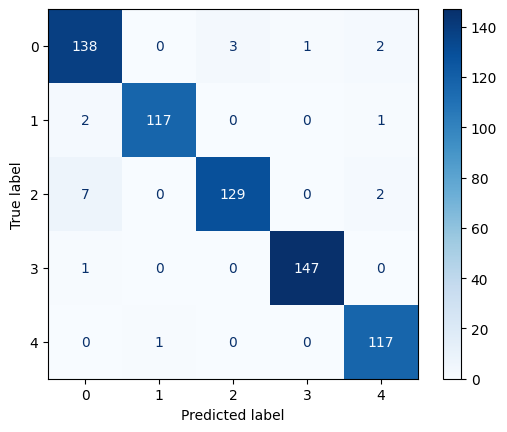

In [54]:
from sklearn.metrics import confusion_matrix

cm_rm_2 = confusion_matrix(le.transform(lb.inverse_transform(np.array(y_test))),ann.predict(x_test).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rm_2)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [55]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(le.transform(lb.inverse_transform(np.array(y_test))),ann.predict(x_test).argmax(axis=1)))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       144
           1       0.99      0.97      0.98       120
           2       0.98      0.93      0.96       138
           3       0.99      0.99      0.99       148
           4       0.96      0.99      0.97       118

    accuracy                           0.97       668
   macro avg       0.97      0.97      0.97       668
weighted avg       0.97      0.97      0.97       668



# Save

In [56]:
# Simpan model dalam format HDF5
ann.save('keras(ANN).h5')  # Ganti dengan nama file yang diinginkan

In [57]:
import pickle

# Menyimpan LabelEncoder
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(le, file)